In [31]:
%config IPCompleter.use_jedi=False
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from Utils import print_memory_usage

In [2]:
data_train = pd.read_parquet("Data/Train.parquet")
print_memory_usage(data_train)
data_train.dtypes

The dataframe needs 1.69 GB of memory


tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                  float64
start station name               category
start station latitude            float64
start station longitude           float64
end station id                    float64
end station name                 category
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                         category
birth year                          int64
gender                              int64
is_roundtrip                         bool
haversine distance                float64
speed                             float64
holiday                              bool
business day                         bool
summer                               bool
dtype: object

## Exploratory Analysis

Lets see how unbalanced the classes are

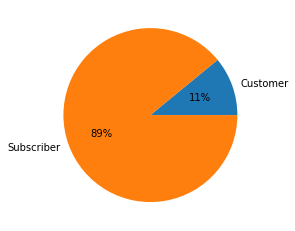

In [3]:
counts = data_train.groupby("usertype").size()
ax = counts.plot.pie(autopct='%1.0f%%',ylabel="")

### Distribution over month

Is this the same for each month?

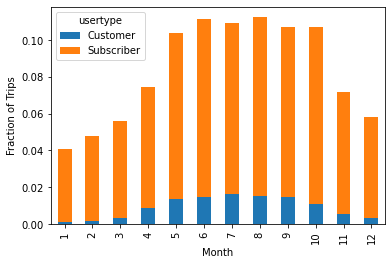

In [4]:
counts = data_train.groupby(by=["usertype",data_train["starttime"].dt.month]).size() / len(data_train)
counts = counts.unstack()
counts = counts.transpose()
ax = counts.plot.bar(stacked=True)
ax.set_xlabel("Month")
_ = ax.set_ylabel("Fraction of Trips")

We see that the amount of Customers varies more strongly with the month than the amount of subscribers.
This is easier to see by looking at the relative proportions of suscribers and customers for each month.

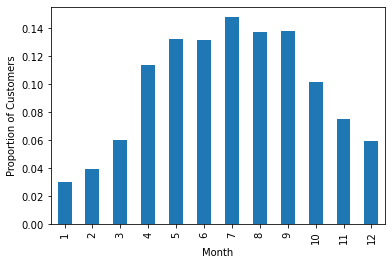

In [5]:
prop = counts.div(counts.sum(axis=1),axis=0)
ax=prop["Customer"].plot.bar(ylabel="Proportion of Customers",xlabel="Month",stacked=True)

### Holiday vs Business Day

Similarly, there are a lot more customers on weekends.

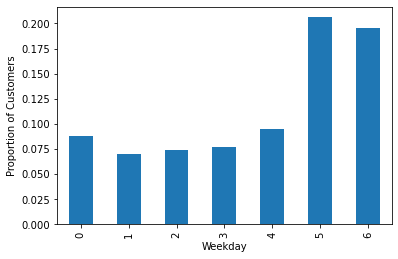

In [7]:
counts=data_train.groupby(by=[data_train["usertype"],data_train["starttime"].dt.dayofweek]).size() / len(data_train)
counts=counts.unstack().transpose()
prop = counts.div(counts.sum(axis=1),axis=0)
ax=prop["Customer"].plot.bar(ylabel="Proportion of Customers",xlabel="Weekday",stacked=True)

### Speed and Roundtrips

TODO: Tripdurations and distances separately

In [8]:
sampled = data_train.sample(n=100000)
sampled["tripduration"] /= 60

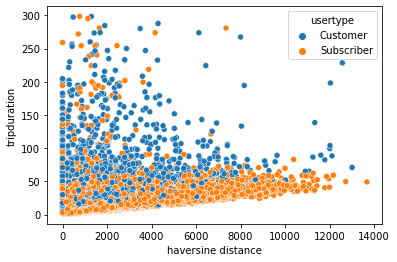

In [10]:
ax=sns.scatterplot(x="haversine distance",y="tripduration",data=sampled,hue="usertype")
del sampled

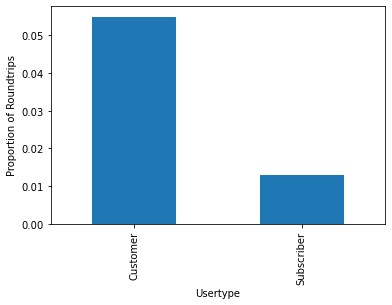

In [12]:
counts = data_train.groupby(["usertype", "is_roundtrip"]).size() / data_train.groupby("usertype").size()
counts=counts.unstack().transpose()
ax = counts.loc[True].plot.bar(ylabel="Proportion of Roundtrips",xlabel="Usertype")

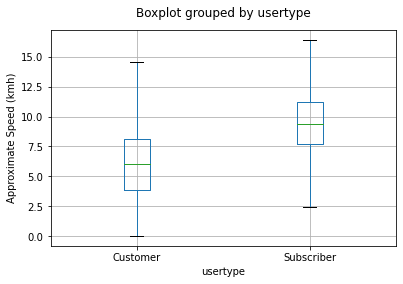

In [14]:
ax=data_train[data_train["is_roundtrip"]==False].boxplot("speed",by="usertype",showfliers=False)
ax.set_title("")
ax.set_ylabel("Approximate Speed (kmh)");

### Gender

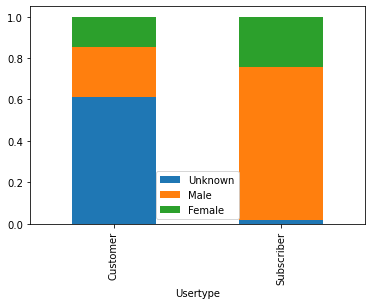

In [15]:
counts = data_train.groupby(["usertype","gender"]).size()
counts = counts/counts.groupby(level=0).sum() #Proportion in each group
counts=counts.unstack()
ax=counts.plot.bar(stacked=True,legend=["unknown","male","female"],xlabel="Usertype")
_=ax.legend(["Unknown","Male","Female"])

We see that for most customers, the gender is unknown, while for almost all subscribers the gender is known. This is potentially a very strong predictor for our model. However, for most use cases, this seems like "cheating". The gender = unknown category does not only mean the gender is unknown, it means that the customer will not provide the gender on registration. This can only be known after the fact, when it is also known whether the user made the trip as a customer or subscriber. Therefore, this is essentially using information "from the future" that will not be available in most use cases.

### Time of day of Trips

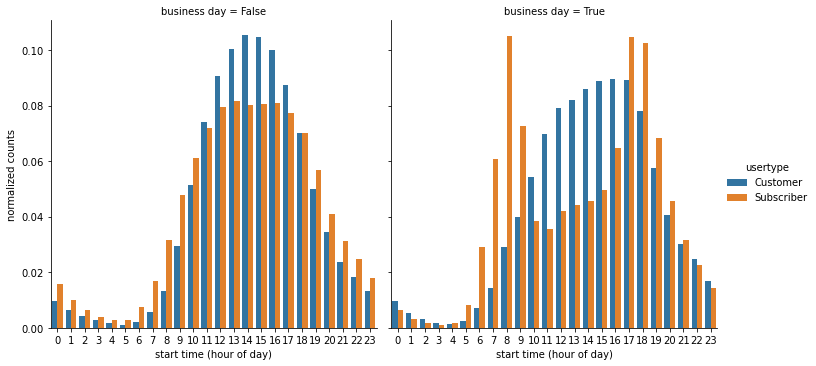

In [16]:
grouped = data_train.groupby(by = [data_train["starttime"].dt.hour,"business day","usertype"]).size()
grouped = grouped / grouped.groupby(level=["business day","usertype"]).sum() #Normlize by dividing by total trips per day
grouped = grouped.reset_index(name="normalized counts")
grouped=grouped.rename(columns={"starttime":"start time (hour of day)"})
sns.catplot(x="start time (hour of day)",y="normalized counts",hue="usertype",col="business day",kind="bar",data=grouped);

We see two interesting facts. The first is that the start times are strongly bimodal for subscribers on business day. Apparently, most subscribers use the bike on their ways to and from work. This is not the case for customers, whose traffic peaks in the afternoon. Thus, we can use the start time to differentiate these two groups.
The second interesting feature is that the difference between customers and subscribers ist far less pronounced on holidays and weekends. Thus, it might make sense to introduce an interaction variable between "start hour" and "business day" into our models.

### Stations

Let us also check if customers and subscribers tend to commute between different stations.

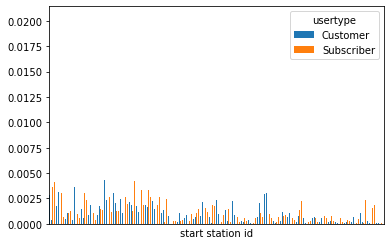

In [19]:
#First, lets just look at the start station
grouped = data_train.groupby(["usertype","start station id"]).size()
grouped = grouped / grouped.groupby(level="usertype").sum() #Normalize over start station ids
grouped_plot = grouped.unstack().transpose()
ax = grouped_plot.plot.bar(by="usertype")
ax.get_xaxis().set_ticks([]);
#ax.set_ylabel("Proportion of Trips from this Station");

We can look at the ten most frequent start stations and see that there is no overlap between customers and subscribers.
Furthermore, customers cluster a bit more around these popular stations.

In [20]:
k=20
grouped = data_train.groupby("usertype")["start station name"].value_counts()
fraction = grouped["Customer"][0:k].sum() / grouped["Customer"].sum()
print(f"The {k} most frequent start stations for customers account for {fraction:.1%} of all customers.")
print(grouped["Customer"][0:k])
fraction = grouped["Subscriber"][0:k].sum() / grouped["Subscriber"].sum()
print(f"The {k} most frequent start stations for subscribers account for {fraction:.1%} of all subscribers.")
print(grouped["Subscriber"][0:k])

The 20 most frequent start stations for customers account for 20.3% of all customers.
start station name
Central Park S & 6 Ave                           31240
Grand Army Plaza & Central Park S                27324
Centre St & Chambers St                          22984
5 Ave & E 88 St                                  20797
12 Ave & W 40 St                                 18877
Central Park West & W 72 St                      16531
5 Ave & E 73 St                                  16168
Pier 40 - Hudson River Park                      14560
West St & Chambers St                            14112
5 Ave & E 78 St                                  13844
Central Park North & Adam Clayton Powell Blvd    13090
Central Park West & W 76 St                      12989
Broadway & W 60 St                               12912
Old Fulton St                                    12150
South End Ave & Liberty St                       11909
Central Park West & W 68 St                      11143
Washington St &

## Birthyear

For some reason, the age of customers is disproportionally often 49 (birthyear = 1969).
I expect that this is the easiest item to select in the list on registration or something like this.

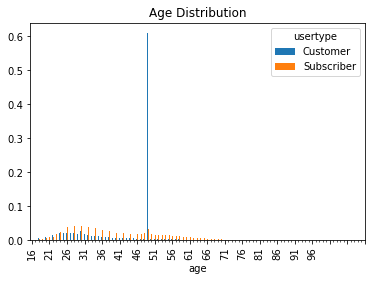

In [39]:
data_train["age"] = 2018 - data_train["birth year"]
counts=data_train.groupby(by=[data_train["usertype"],data_train["age"]]).size()
counts = counts / counts.groupby("usertype").sum()
counts=counts.unstack().transpose()
ax = counts.plot.bar(by="usertype")
ax.set_title("Age Distribution");
ax.set_xticks(np.arange(0,96,5));
ax.set_xticks(np.arange(0,96,1),minor=True);
#plt.tick_params(axis='x', which='major', labelsize=3)

Apart from this, the age distribution is relatively similar.
Customers do tend to be slightly younger.

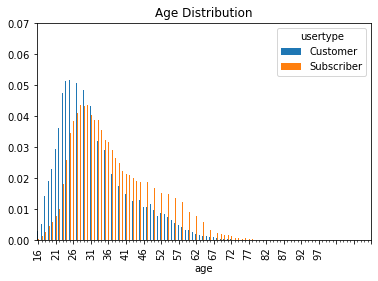

In [44]:
counts=data_train[data_train["age"]!=49].groupby(by=["usertype","age"]).size()
counts = counts / counts.groupby("usertype").sum()
counts=counts.unstack().transpose()
ax = counts.plot.bar(by="usertype")
ax.set_title("Age Distribution");
ax.set_xticks(np.arange(0,96,5));
ax.set_xticks(np.arange(0,96,1),minor=True);